<center>
    <h1>Project 1</h1>
    <h2>TMA4320 Introduksjon til vitenskapelige beregninger</h2>
</center>

---
An important concern regarding the increasing amount of CO<sub>2</sub> in the atmosphere is that it leads to acidification of the ocean. This will cause severe problems to the marine life.

In this project we will be looking into a simplified water-column model for the ocean. We will use this model to predict how the ocean absorbs CO<sub>2</sub> from the atmosphere, dissolves it and diffuses it to greater depths. In the ocean, CO<sub>2</sub> is stored as dissolved inorganic carbon (DIC).

## Importing libraries

In [1]:
# Matplotlib for plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib notebook
%matplotlib inline

# Numpy for almost everything
import numpy as np

# Some scipy functions for sparse diagonal matrices
from scipy.sparse import diags

# scipy function to numerically calculate integral
from scipy.integrate import simps

# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
from numba import jit

## Change settings of the figures

In [2]:
# Setting the dpi of the figure to 180 dpi (for better quality)
mpl.rcParams['figure.dpi'] = 180

# Defining some figure parameters
mpl.rcParams.update({'figure.figsize': (11.0, 7.5),                   # Figuresize
                     'legend.fontsize': 17, 'legend.handlelength': 3, # Legend
                     'xtick.labelsize': 15, 'ytick.labelsize': 15,    # Tick-sizes of the axes
                     'font.size': 15,                                 # Fontsize
                     'axes.grid': True,})                             # Enabling gridlines

## Function to solve systems of equations

In [3]:
# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse diagonal matrix structure into separate diagonals,
    # and pass them to the numba-compiled solver defined above.
    # Note, this method needs A to be diagonally dominant
    # (which it will be, for this problem)
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

<center>
    <h1>Problem 1</h1>
    <h2>Response to changing CO<sub>2</sub> concentration in shallow areas</h2>
</center>

---

In this problem we will be looking into how the water at a depth of 100 meters responds to a change in the atmospheric concentration of CO<sub>2</sub>, and how quick it reaches equilibrium with the atmosphere. We will assume conditions where the water near the surface is affected by wind and the water near the sea floor is affected by friction.

## Defining lists and variables

In [4]:
z_f = 100      # Depth of the column
t_f = 15552000 # Seconds in 180 days
N = 9999       # Size of system is N+1

z = np.linspace(0,z_f,N+1)    # Array from 0 to z_f with N+1 points
t = np.linspace(0,t_f,N+1)    # Array from 0 to t_f with N+1 points
dt = t_f/N                    # Time-step
dz = z_f/N                    # Length-step
days = np.linspace(0,180,N+1) # List with N+1 points from 0 to 180 to plot in days and not in second later

# Some constants:
alfa = dt/(2*dz**2)   # s/m^2
H = 5060              # mol/(m^3*atm)
p_co2 = 415*10**(-6)  # atm
C_eq = H*p_co2        # mol/m^3. Denne er konstant i oppgave 1
k_w = 6.97*10**(-5)   # m/s
K_0 = 10**(-3)        # m^2/s
K_a = 2*10**(-2)      # m^2/s
z_a = 7               # m
K_b = 5*10**(-2)      # m^2/s
z_b = 10              # m

# Creating K-array
K = np.zeros(N+1)
for i in range(len(K)):
    K[i] = K_0 + K_a*(z[i]/z_a)*np.exp(-z[i]/z_a) + K_b*((z_f-z[i])/z_b)*np.exp(-(z_f-z[i])/z_b)

# Creating Gamma
gamma = 2*alfa*k_w*dz*(1-((K[1]-K[0])/(2*K[0])))

# Creating K'-array
Km = np.zeros(N)
for i in range(1,len(Km)):  # We wont be using K[0] so we let it stay 0. We go from Km[1]
    Km[i] = K[i+1]-K[i-1]

# Creating S
S = np.zeros(N+1)     # S is constant in problem 1
S[0] = 2*gamma*C_eq   # Defining the first value of S
S_t = np.transpose(S) # Transpose of S
C_0 = np.zeros(N+1)   # Zero initial concentration of DIC in the ocean

## Making L and R sparse matrices

In [5]:
# Creating the three diagonals to the matrix R
R_main  = np.zeros(N+1) 
R_upper = np.zeros(N)
R_lower = np.zeros(N)

# Filling the diagonals:
R_main[0] = 1 - 2*alfa*K[0] - gamma  # Defining the first value as it has a different expression
for i in range(1, len(R_main)): 
    R_main[i] = 1-(2*alfa*K[i])
    
R_upper[0] = 2*alfa*K[0]             # Defining the first value as it has a different expression
for i in range(1, len(R_upper)):
    R_upper[i] = ((alfa/4)*Km[i]) + (alfa*K[i])

R_lower[N-1] = 2*alfa*K[N]           # Defining the last value as it has a different expression
for i in range(len(R_lower)-1):
    R_lower[i] = ((-alfa/4)*Km[i+1]) + (alfa*K[i+1])

In [6]:
# Creating the three diagonals to the matrix L
L_main  = np.zeros(N+1)
L_upper = np.zeros(N)
L_lower = np.zeros(N)

# Filling the diagonals:
L_main[0] = 1 + 2*alfa*K[0] + gamma  # Defining the first value as it has a different expression
for i in range(1, len(L_main)):
    L_main[i] = 1 + (2*alfa*K[i])
    
L_upper[0] = -2*alfa*K[0]            # Defining the first value as it has a different expression
for i in range(1,len(L_upper)):
    L_upper[i] = ((-alfa/4)*Km[i])-(alfa*K[i])
    
L_lower[N-1] = -2*alfa*K[N]          # Defining the last value as it has a different expression
for i in range(len(L_lower)-1): 
    L_lower[i] = ((alfa/4)*Km[i+1])-(alfa*K[i+1])

In [7]:
# Creating sparse matrices
# Give a list of the diagonals, and a corresponding list of offsets
# offset of 0 is the main diagonal, offset -1 is the first lower diagonal, etc.
R = diags([R_upper, R_main, R_lower], offsets = [1, 0, -1]) 
L = diags([L_upper, L_main, L_lower], offsets = [1, 0, -1])

## TASK 1.1: Simulation of the change in concentration of DIC in the sea for 180 days

In [8]:
C = np.zeros(shape=(N+1,N+1)) # Creating a (N+1)x(N+1) matrix with zeros
C[0]=C_0                      # Initial concentration

for i in range(N): 
    V = R.dot(C[i]) + (1/2)*(S+S) # Solving V for each C_i
    C[i+1] = tdma(L,V)            # Solving the system of equation L*C=V and move it into the matrix

# Transposing C:
C_t = np.transpose(C) 

By running a simulation we can see the change in concentration of DIC in the ocean. This is done by creating a matrix $\textbf{C}$ for the concentration, and asserting the initial concentration as the first array in the matrix for the first time-value. The array $\textbf{C}^i$ is then used with the sparse matrix $\textbf{R}$ and array $\textbf{S}$ to calculate $\textbf{V}$ $(27)$:
<br>
<center>
$\textbf{V}  = \textbf{RC} ^i + \frac{1}{2} (\textbf{S}^i + \textbf{S}^{i+1})$
</center>

In problem 1, $\textbf{S}^i$ and $\textbf{S}^{i+1}$ are equal because the equilibrium consentration is constant. The solution for $\textbf{V}$ is now used with the sparse matrix $\textbf{L}$ to solve for the next array $\textbf{C}^{i+1}$ from $\textbf{C}$ in equation $(28)$:
<br>
<center>
$\textbf{LC}^{i+1}  = \textbf{V}$
</center>

<br>
When this process is completed, matrix $\textbf{C}$ will have arrays $\textbf{C}^i$ consisting of the concentrations of CO<sub>2</sub> for all depths for a specific time. It is necessary to transpose $\textbf{C}$ to get $\textbf{C}^T$ where the elements $\textbf{C}^{T,i}$ are arrays containing concentrations for specific depth for our time interval.

## TASK 1.2: Plot of the highest and lowest concentration of DIC

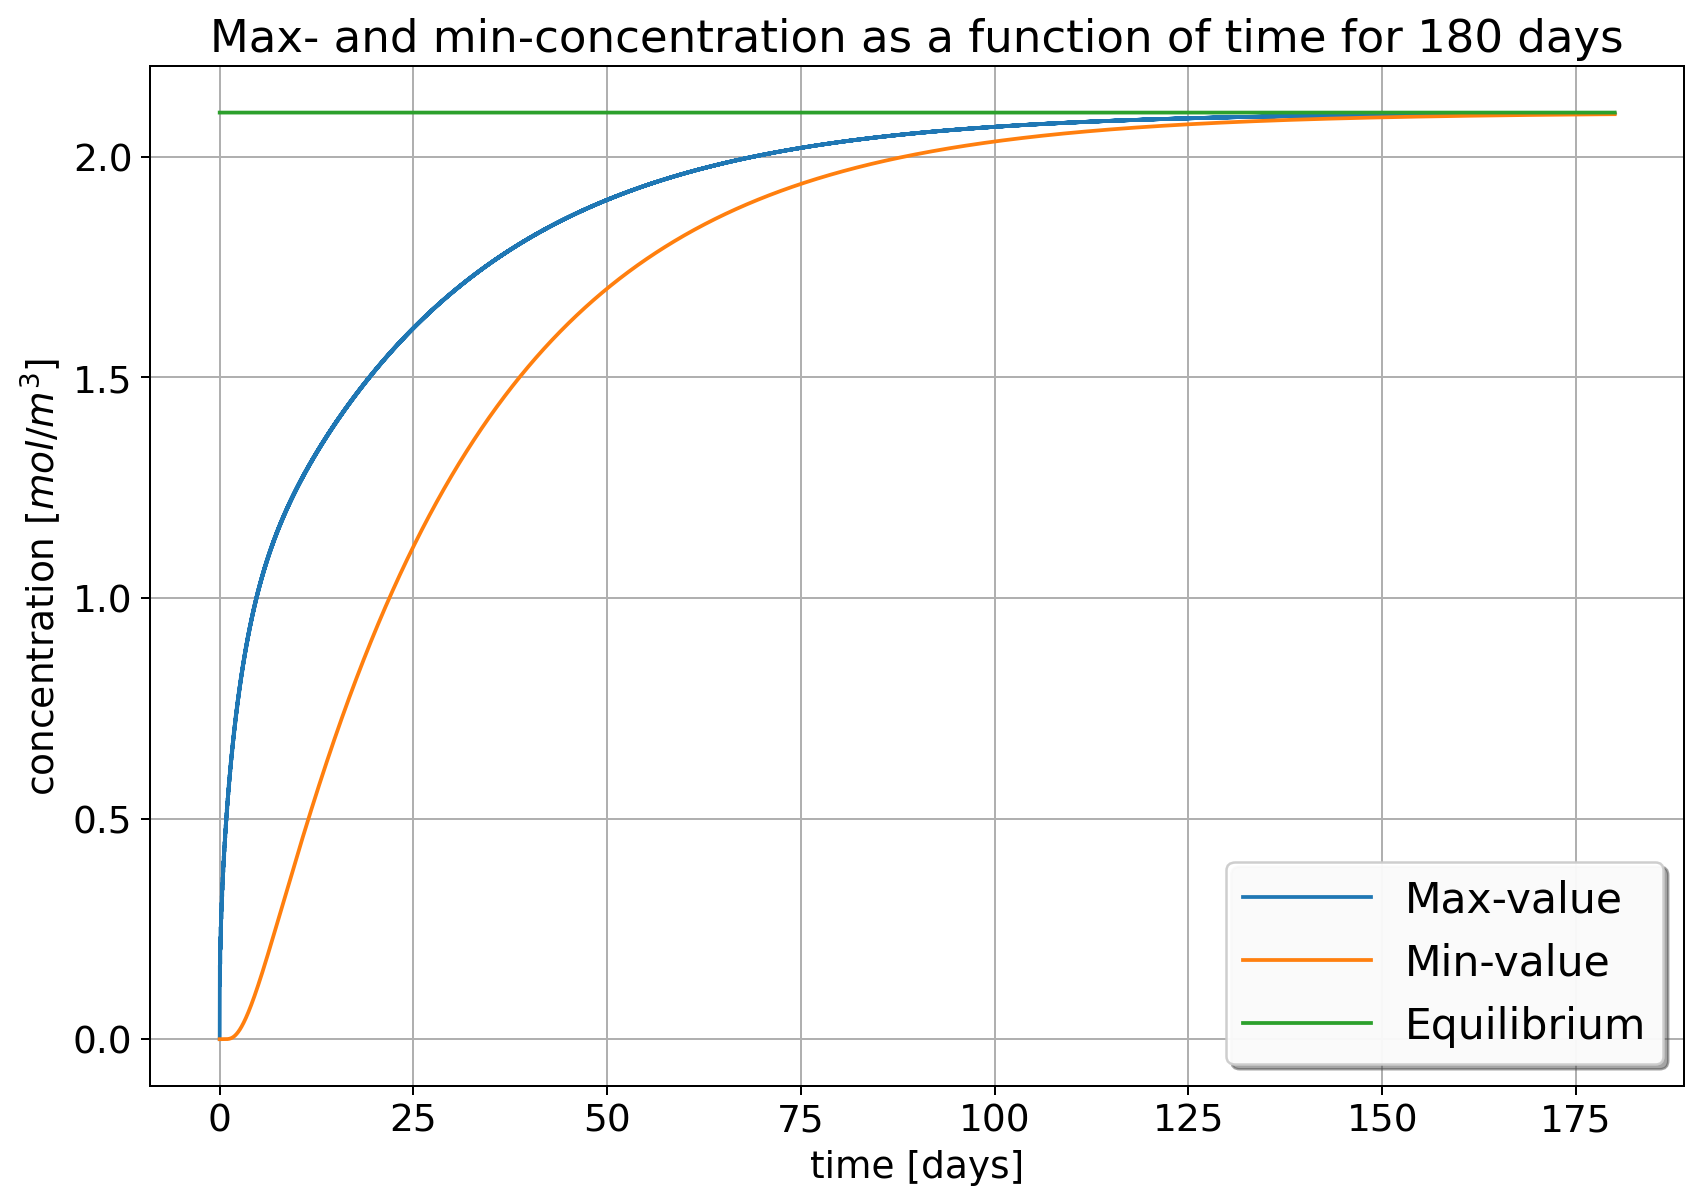

In [9]:
# Making an array with the equilibrium-concentration for plotting
C_eq_array = np.ones(N+1) * C_eq

z_max = np.zeros(N+1) # Creating (N+1)-matrix with zeros
z_min = np.zeros(N+1) # Creating (N+1)-matrix with zeros

for i in range(N+1):
    z_max[i] = np.max(C[i]) # Using np.max to find the max-value of each array in the matrix
    z_min[i] = np.min(C[i]) # Using np.min to find the min-value of each array in the matrix

# Plotting the max- and min-concentration as a function of time for 180 days
plt.figure()
plt.title('Max- and min-concentration as a function of time for 180 days', fontsize = 18)
plt.plot(days, z_max, label='Max-value')
plt.plot(days, z_min, label='Min-value')
plt.plot(days, C_eq_array, label='Equilibrium')
plt.xlabel('time [days]')
plt.ylabel('concentration [$mol/m^3$]')
plt.legend(fancybox=True, framealpha=0.95, shadow=True)
plt.show()

For each $\textbf{C}^i$ (concentration for each time) the maximum- and minimum-values are found and plotted in the figure above. The blue graph is the maximum-concentration in the ocean as a function of time, and the orange graph is the minimum-concentration. 


In the first 25 days the minimum-values of the concentration will increase slower than the maximum-value. After 180 days the concentrations have reached equilibrium.

## TASK 1.3: Plotting the concentration as a function of depth for different times

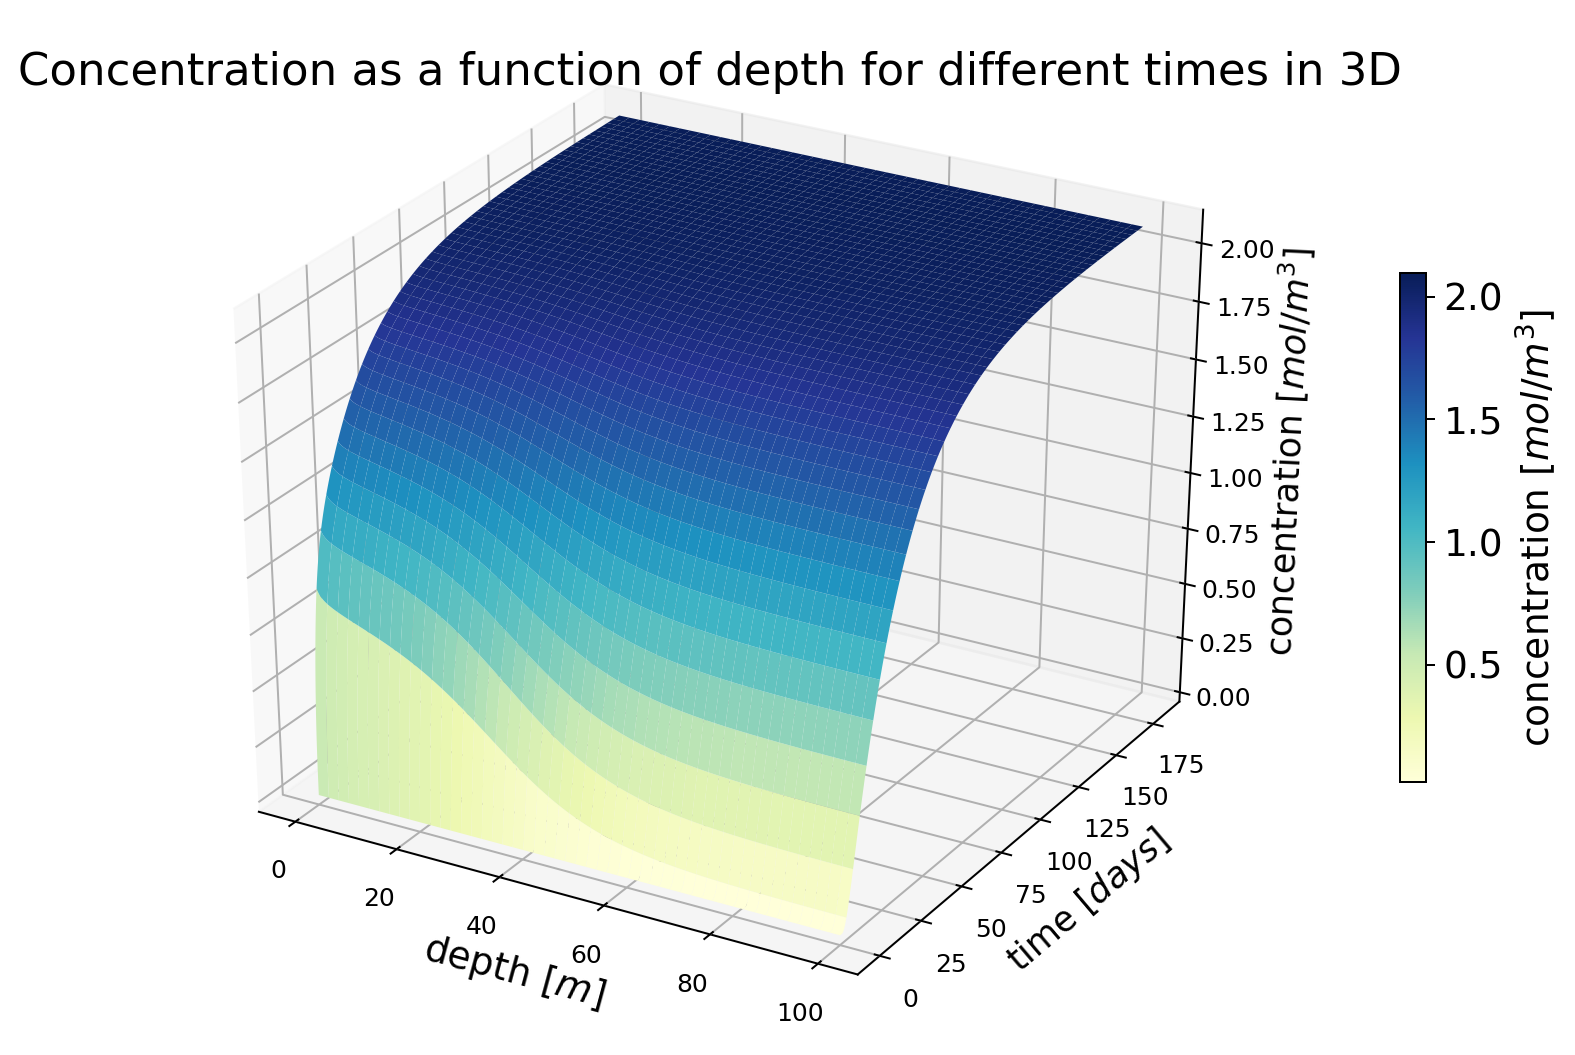

In [10]:
# Making a 3D-plot:
# Meshgrid for 3D-plot
zz, daysdays = np.meshgrid(z,days)

# 3D-plotting
fig = plt.figure()
ax = fig.gca(projection = '3d')
plt.title('Concentration as a function of depth for different times in 3D', fontsize = 18)
surf = ax.plot_surface(zz, daysdays, C, cmap='YlGnBu')

# Setting labels to axis
ax.set_xlabel('depth [$m$]', fontsize=15)
ax.set_ylabel('time [$days$]', fontsize=14)
ax.set_zlabel('concentration [$mol/m^3$]', fontsize=14)

# Making smaller axis-ticks
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.zaxis.set_tick_params(labelsize=10)

# Adding color bar
cbar = fig.colorbar(surf, shrink=0.5)
cbar.set_label('concentration [$mol/m^3$]')
plt.show()

A representation of the increase in concentration can be seen at the 3D-plot where concentration is plotted for different depths and time (in days) simultaneously.

In the beginning there is some concentration of CO<sub>2</sub> at the sea surface, and approximately zero concentration at the sea floor. As more CO<sub>2</sub> enters the ocean from the atmosphere across the air-sea interface, more of it will distribute downwards towards the sea floor by diffusion. By 180 days, the concentration in the ocean has reached equilibrium and is the same for all depths of the sea. To understand the change in concentration, we can look at the diffusivity.

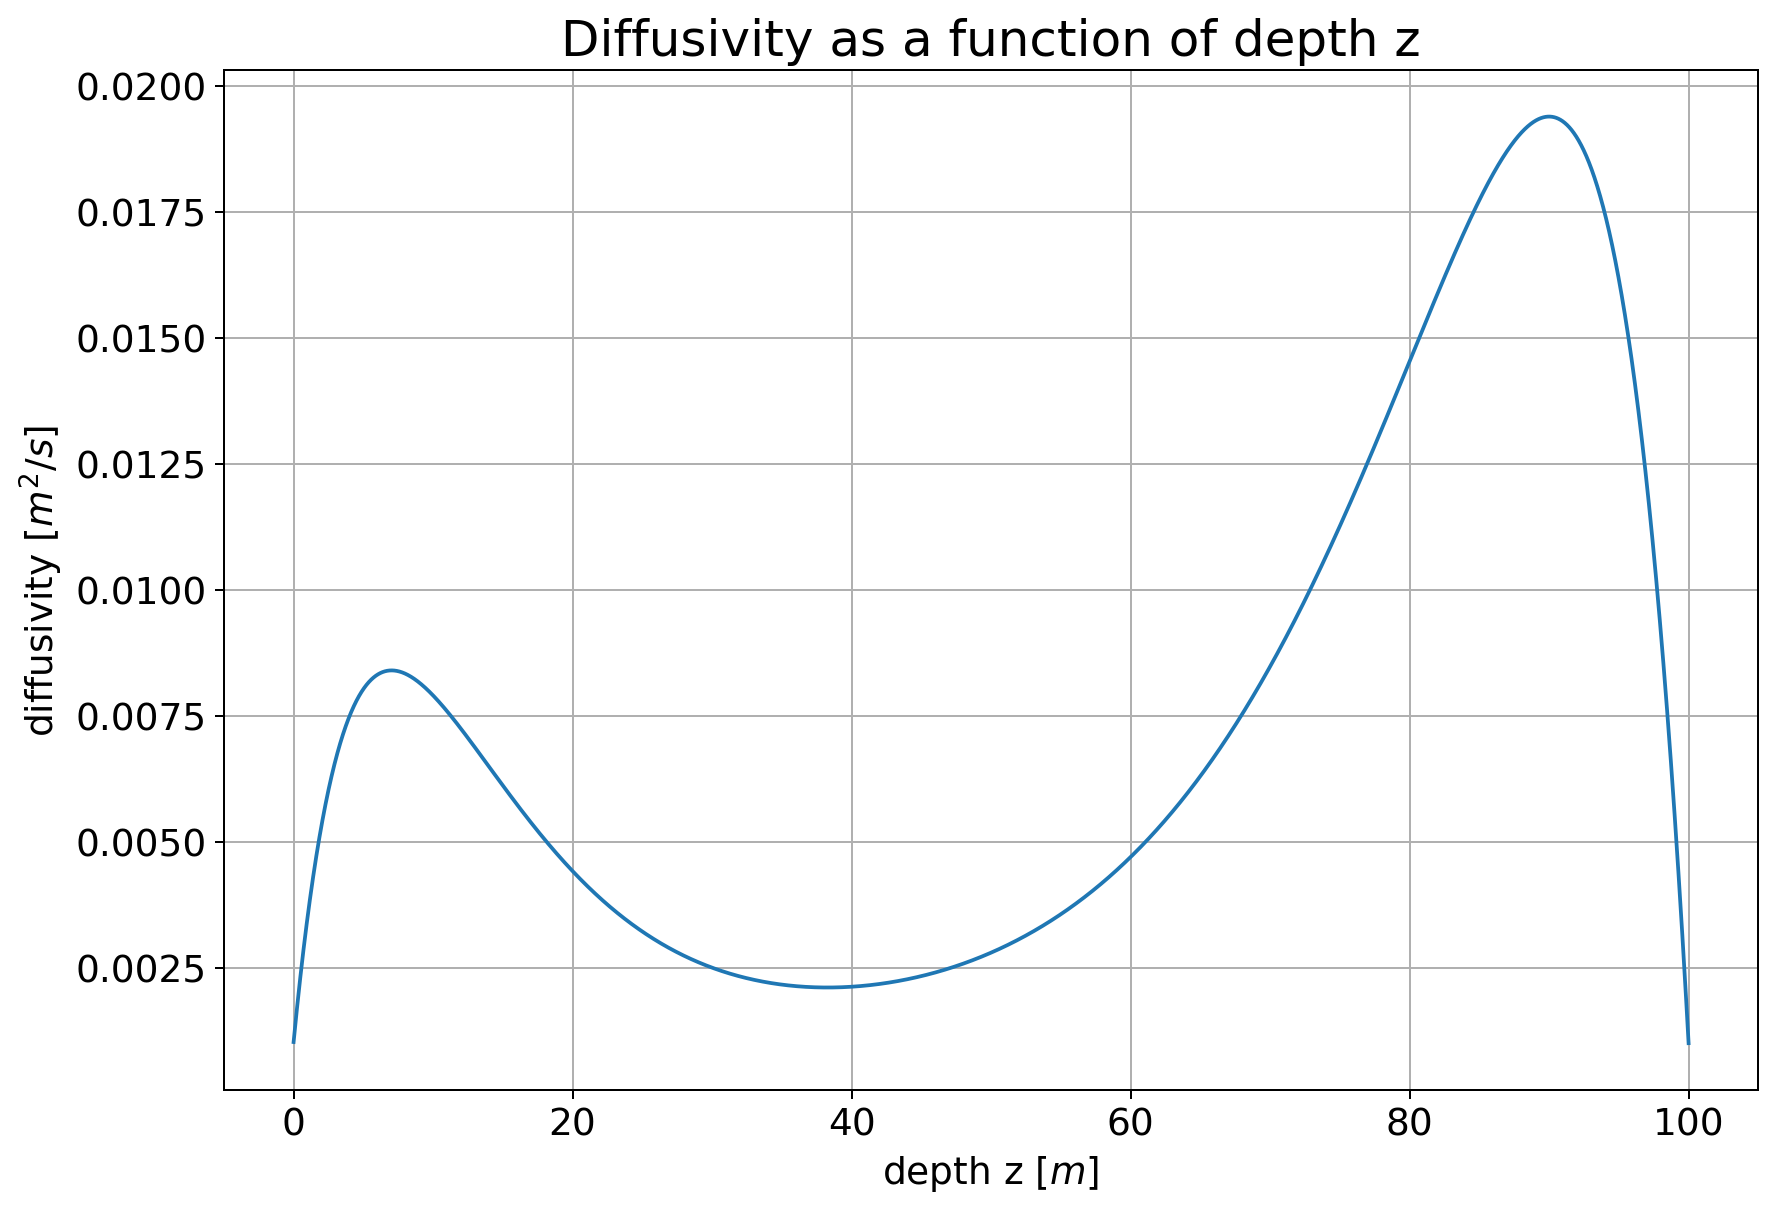

In [11]:
# Plotting diffusivity
plt.figure()
plt.title('Diffusivity as a function of depth z', fontsize=20)
plt.xlabel('depth z [$m$]')
plt.ylabel('diffusivity [$m^2/s$]')
plt.plot(z,K)
plt.show()

The figure shows that the diffusivity has two maxima: One close to the sea surface and one larger and closer to the sea floor. The diffusivity is small between the two maxima. From the 3D-plot of the concentration we see that the concenctration significally reduces from a depth of 20 meters to  60 meters. As shown in the diffusivity-graph, this is an area with low diffusivity, and therefore takes more time for the concentration to diffuse down in this area, than it does to diffuse in the surface layers and the deeper layers. That is why we see a rather steep descent of concentration from around 20 to 60 meters. This corresponds with our assumption of the expression for the diffusivity K: The water near the surface is affected by wind, and water near the sea floor is affected by friction of the current. Both of these cases will lead to an increase of diffusion.

## TASK 1.4: Checking the synchronisation of changes of DIC

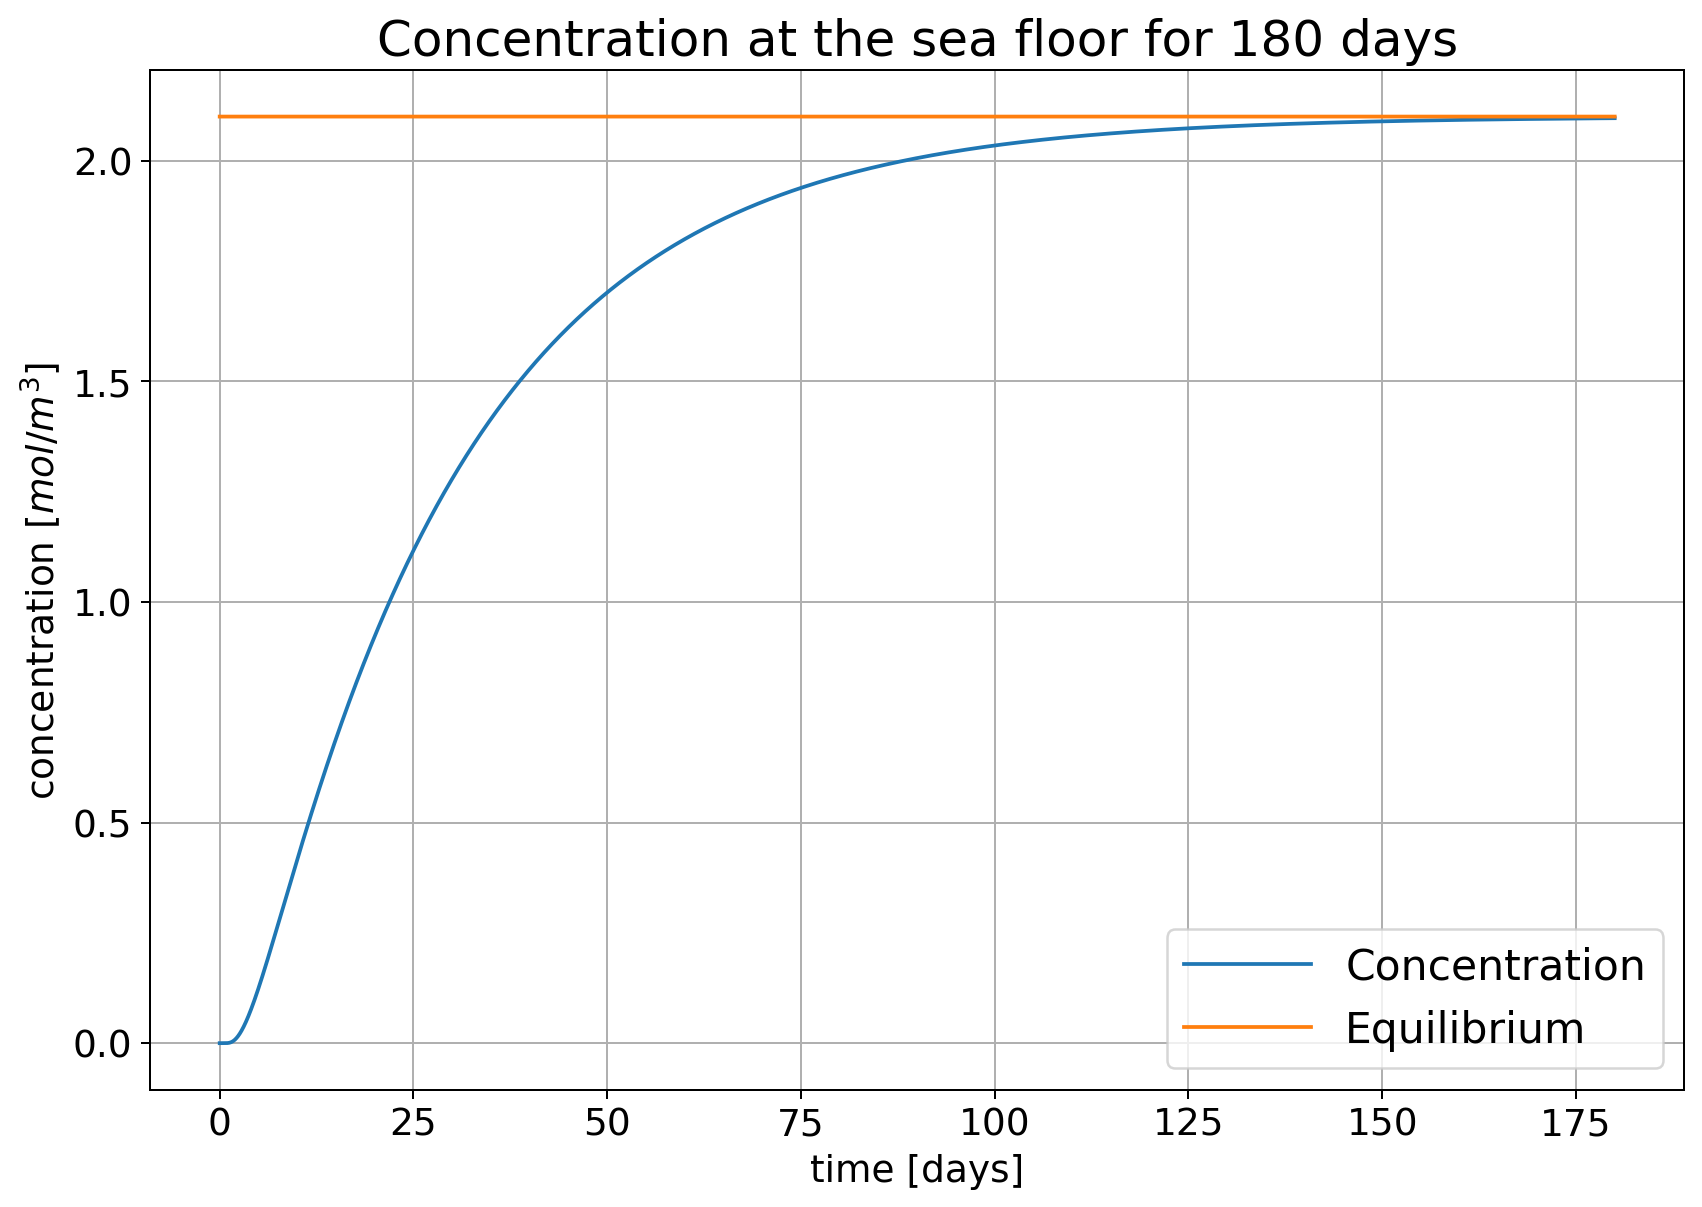

In [12]:
# Plotting the concentration at the sea floor as a function of time for 180 days
plt.figure()
plt.title('Concentration at the sea floor for 180 days', fontsize = 20)
plt.plot(days, C_t[N], label='Concentration')  #C[N] is the concentration at the sea floor for different times
plt.plot(days, C_eq_array, label='Equilibrium')
plt.xlabel('time [days]')
plt.ylabel('concentration [$mol/m^3$]')
plt.legend()
plt.show()

When assuming zero initial concentration of DIC in the ocean and 415 ppm CO<sub>2</sub> in the atmosphere, it will take approximately 180 days until the concentration by the sea floor (thus the whole sea) reaches equilibrium at approximately 2.1 mol/m<sup>3</sup>. 

In figure 3 the concentration of CO<sub>2</sub> is represented as a graph over the past 270 years. The growth rate is fairly even until close to year 2000 where the concentration increases linear of about 2.3 ppm/year. By equation (4), 2.3 ppm corresponds to a concentration of 0.012 mol/m<sup>3</sup> CO<sub>2</sub>. 

If it takes 180 days for the ocean to absorb 2.1 mol/m<sup>3</sup> CO<sub>2</sub>, it will be able to adjust to the yearly increase of 0.012 mol/m<sup>3</sup> CO<sub>2</sub> in the atmosphere. From this we can draw the conclusion that the water at 100 meters depth is "in sync" with the changes in the atmosphere.

<center>
    <h1>Problem 2</h1>
    <h2>CO<sub>2</sub> absorption by the deep ocean</h2>
</center>

---

In this problem we will now assume an increase of 2.3 ppm CO<sub>2</sub> per year in the atmosphere. The water depth has also been increased to 4000 meters, which is approximately the average depth of the ocean. We will assume a high diffusivity in the surface mixed layers and a low diffusivity in the deep ocean. At the end we will look at the total mass of DIC in the sea.

## Defining lists and variables

In [13]:
z_f = 4000       # Depth of the ocean and also the end value of z
t_f = 315569260  # Total seconds in 10 years
N = 9999         # Size of system is N+1

z = np.linspace(0,z_f,N+1)    # Array from 0 to z_f with N+1 points
t = np.linspace(0,t_f,N+1)    # Array from 0 to t_f with N+1 points
dt = t_f/N                    # Time-step
dz = z_f/N                    # Lenght-step
years = np.linspace(0,10,N+1) # List with N+1 points from 0 to 180 to plot in days and not in second later

# This time p_CO2 is an array with N+1 points
p_CO2=np.zeros(N+1)

# 10 000 points in 10 years => 1000 points each year
# CO2 increases by 2.3*10^(-6)/1000 each year
dCO2 = 2.3*10**(-6)/1000 #atm
for i in range(N+1):
    p_CO2[i]=415*10**(-6)+(dCO2*i) #atm

# Some constants:
alfa = dt/(2*dz**2)  # s/m^2
H = 5060             # mol/(m^3*atm)
C_eq = H*p_CO2       # mol/m^3
k_w = 6.97*10**(-5)  # m/s
K_0 = 10**(-4)       # m^2/s
K_1 = 10**(-2)       # m^2/s
a = 0.5              # m^-1
z_0 = 100            # m

# Creating K-array
K = np.zeros(N+1)
for i in range(len(K)):
    K[i] = K_1 + ((K_0-K_1)/(1+np.exp(-a*(z[i]-z_0))))

# Creating Gamma
gamma = 2*alfa*k_w*dz*(1-((K[1]-K[0])/(2*K[0]))) 

# Creating K'-array
Km = np.zeros(N) 
for i in range(1,len(Km)):  # We wont be using K[0] so we let it stay 0. We go from Km[1]
    Km[i] = K[i+1]-K[i-1]

# Creating S
# In problem 2, S will be varying so we use a matrix
S = np.zeros(shape=(N+1,N+1)) # Creating (N+1)x(N+1) matrix with zeros
for i in range(N+1):
    S_i = np.zeros(N+1)       # Create an empty array
    S_i[0] = 2*gamma*C_eq[i]  # Defining the first element of the array
    S[i] = S_i                # Putting the array in the matrix

S_t = np.transpose(S)         # Transposing S

# Multiplying 415ppm (atm) with H (mol/(m^3*atm)) to get the desired initial concentration in unit mol/m^3
C_0 = (np.ones(N+1))*H*415*10**(-6) 

## Making L and R sparse matrices

In [14]:
# Creating the three diagonals to the matrix R
R_main  = np.zeros(N+1) 
R_upper = np.zeros(N)
R_lower = np.zeros(N)

# Filling the diagonals:
R_main[0] = 1 - 2*alfa*K[0] - gamma  # Defining the first value as it has a different expression
for i in range(1, len(R_main)):
    R_main[i] = 1-(2*alfa*K[i])

R_upper[0] = 2*alfa*K[0]             # Defining the first value as it has a different expression
for i in range(1, len(R_upper)):
    R_upper[i] = ((alfa/4)*Km[i]) + (alfa*K[i])
    
R_lower[N-1] = 2*alfa*K[N]           # Defining the last value as it has a different expression
for i in range(len(R_lower)-1):
    R_lower[i] = ((-alfa/4)*Km[i+1]) + (alfa*K[i+1])

In [15]:
# Creating the three diagonals to the matrix L
L_main  = np.zeros(N+1)
L_upper = np.zeros(N)
L_lower = np.zeros(N)

# Filling the diagonals:
L_main[0] = 1 + 2*alfa*K[0] + gamma  # Defining the first value as it has a different expression
for i in range(1, len(L_main)):
    L_main[i] = 1 + (2*alfa*K[i])
    
L_upper[0] = -2*alfa*K[0]            # Defining the first value as it has a different expression
for i in range(1,len(L_upper)):
    L_upper[i] = ((-alfa/4)*Km[i])-(alfa*K[i])

L_lower[N-1] = -2*alfa*K[N]          # Defining the last value as it has a different expression
for i in range(len(L_lower)-1): 
    L_lower[i] = ((alfa/4)*Km[i+1])-(alfa*K[i+1])

In [16]:
# Creating sparse matrices
# Give a list of the diagonals, and a corresponding list of offsets
# offset of 0 is the main diagonal, offset -1 is the first lower diagonal, etc.
R = diags([R_upper, R_main, R_lower], offsets = [1, 0, -1])
L = diags([L_upper, L_main, L_lower], offsets = [1, 0, -1])

## Task 2.1: Simulation of concentration of DIC for 10 years

In [17]:
C = np.zeros(shape=(N+1,N+1)) # Creating (N+1)x(N+1) matrix with zeros
C[0]=C_0                      # Initial concentration

for i in range(N): 
    V = R.dot(C[i]) + (1/2)*(S[i]+S[i+1]) # Solving V for each C_i
    C[i+1] = tdma(L,V)                    # Solving the system of equation L*C=V and move it into the matrix

# Transposing C so we get the time as each columns and not rows as in C
C_t = np.transpose(C) 

The method of calculating $\textbf{C}$ is the same as in task 1.1, but this time $\textbf{S}^i$ and $\textbf{S}^{i+1}$ are different because the equilibrium-concentration is changing with time.

## Task 2.2: Plot of the concentration

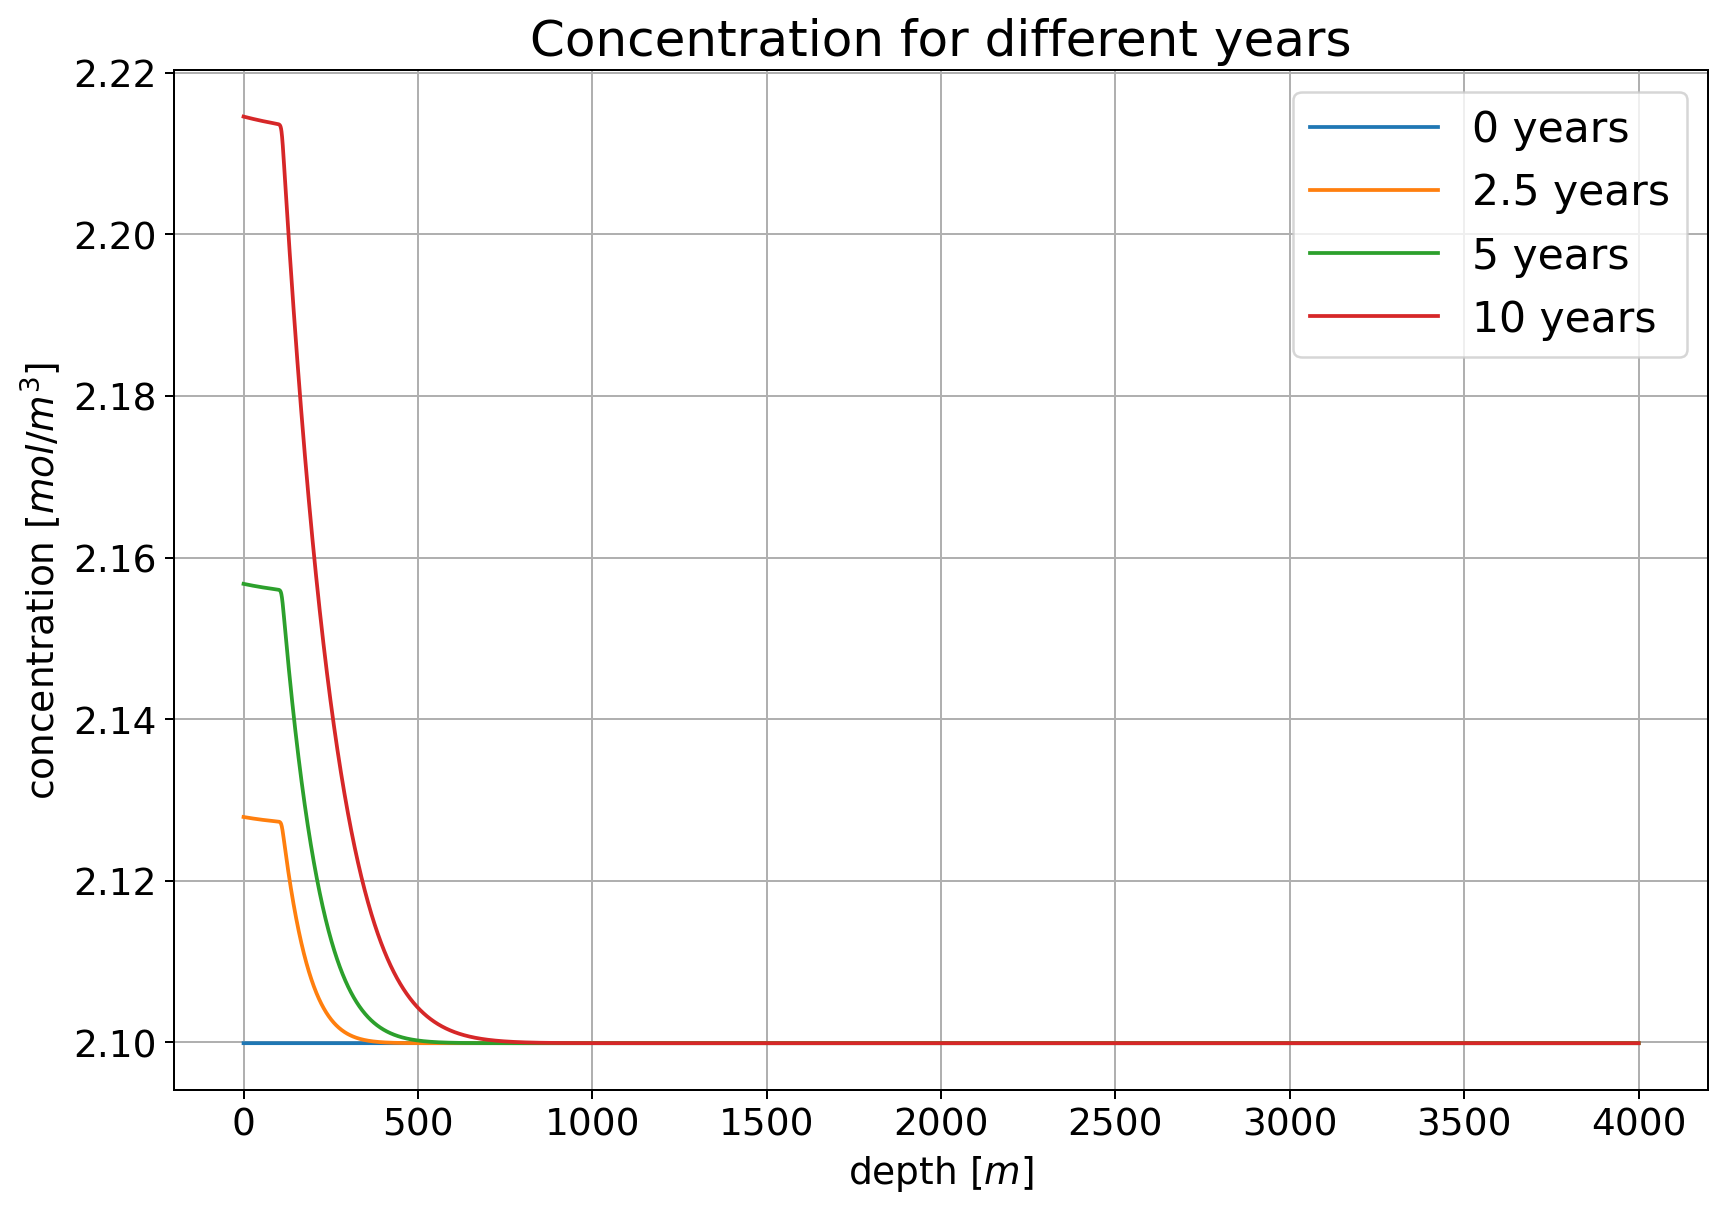

In [18]:
one_year = int(np.floor(31556926/dt)) # Finding the point that correspond to a year

# Plotting the concentration as a function of depth for 0, 2.5, 5 and 10 years
plt.figure()
plt.title('Concentration for different years', fontsize = 20)
plt.plot(z, C[0], label='0 years')
plt.plot(z, C[int(np.floor(one_year * 2.5))], label='2.5 years') # Desperate attempt on making it to an int
plt.plot(z, C[one_year * 5], label='5 years')
plt.plot(z, C[one_year * 10], label='10 years') 
plt.xlabel('depth [$m$]')
plt.ylabel('concentration [$mol/m^3$]')
plt.legend()
plt.show()

The plot of the concentration shows that the concentration of DIC increases with time, which corresponds to the concentration of CO<sub>2</sub> in the atmosphere increasing linear.

We see that the concentration in the deep ocean approaches the initial concentration (blue) of 2.1 mol/m<sup>3</sup>. This means that there has been minimal diffusion in the deep ocean, which corresponds to the low diffusivity-value that is found in the diffusivity graph below.

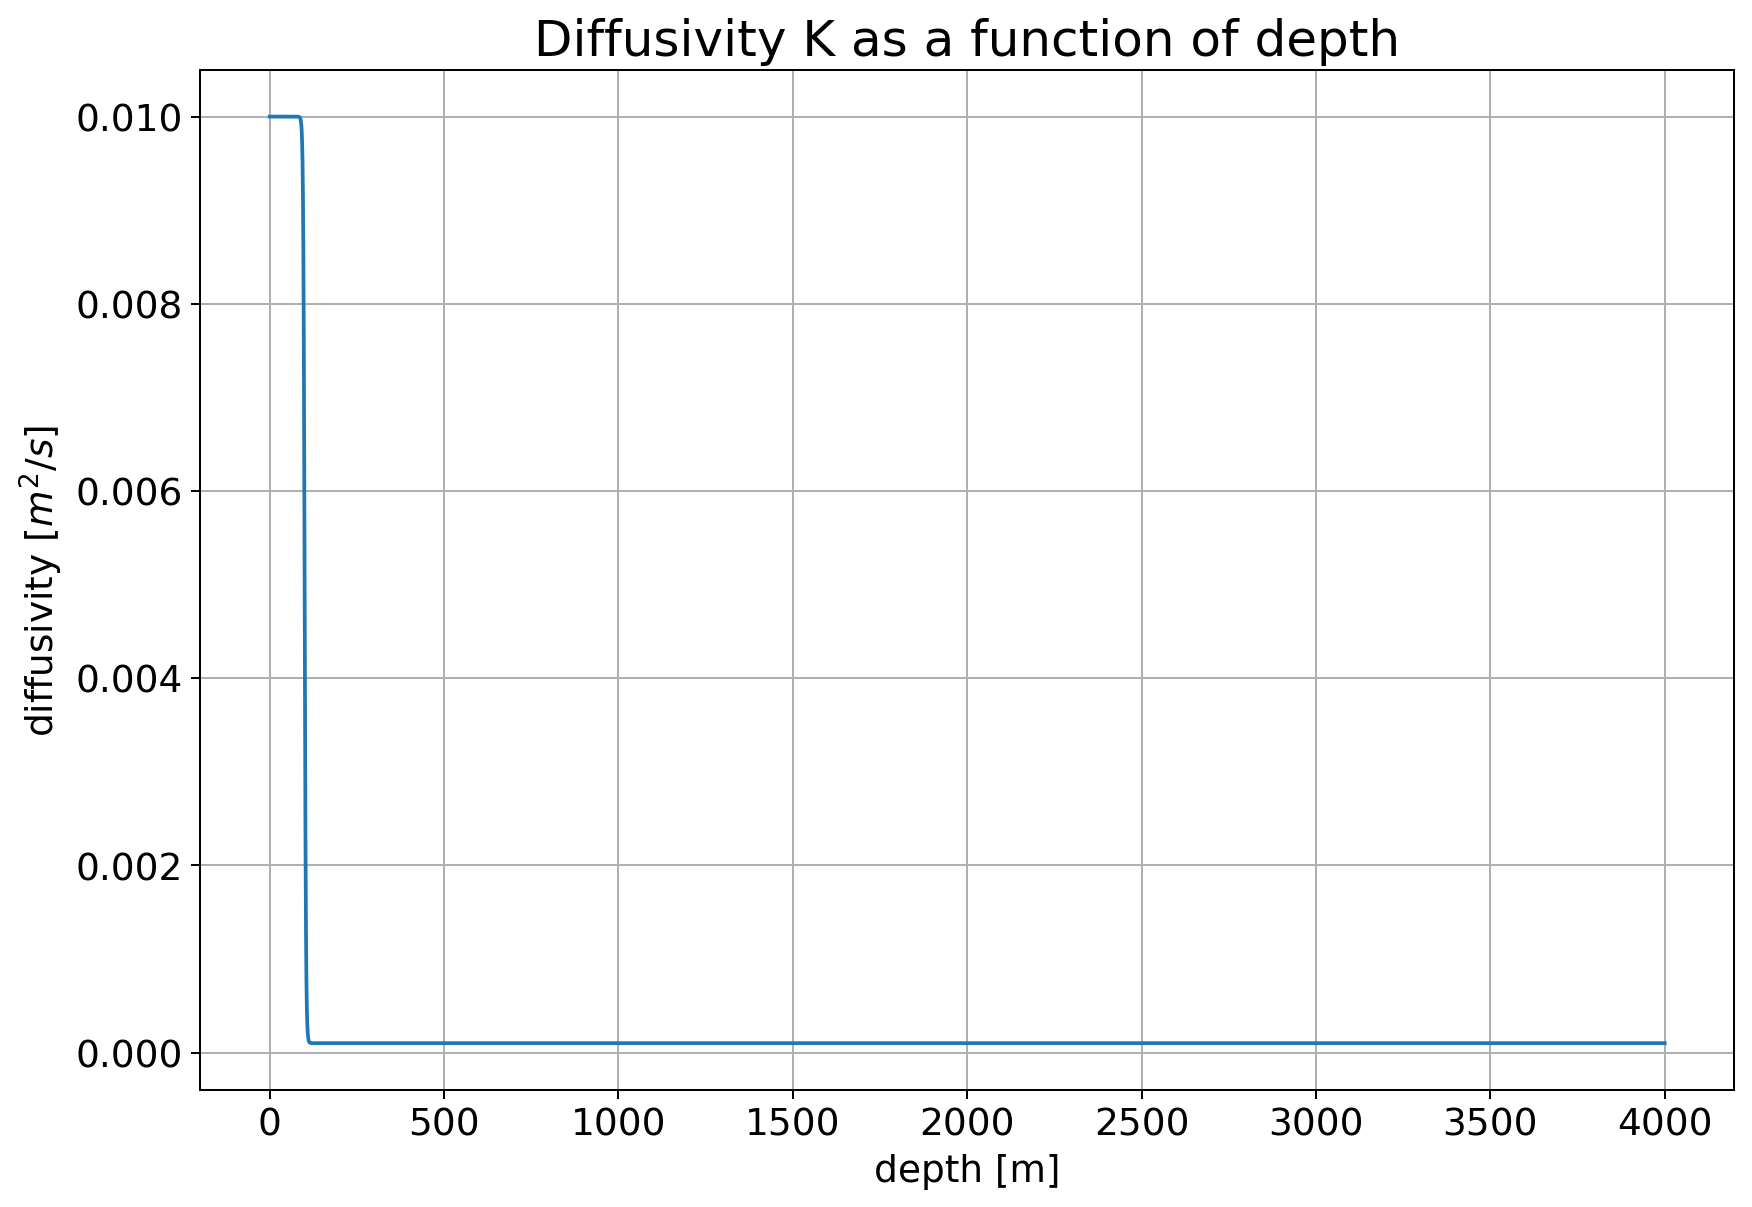

In [19]:
# Plotting the diffusivity K to see that it corresponds with the plot of concentration above
plt.figure()
plt.title('Diffusivity K as a function of depth', fontsize = 20)
plt.plot(z, K)
plt.xlabel('depth [m]')
plt.ylabel('diffusivity [$m^2/s$]')
plt.show()

The plot of the diffusivity shows that the diffusivity is large in the interval from the sea surface to approximately 100 meters, and then apporixmately equal to zero further down. According to figure 2 in the project description, the surface is affected by wind, which helps to diffuse the concentration in the surface-layer. The first 100 meters is a so-called mixed layer where turbulence increases CO<sub>2</sub>-mixture in the water. This corresponds to the sigmoid-function for the diffusivity K where there is a higher diffusivity in the mixed layer and a lower diffusivity in the deep ocean, which explains the sudden fall of concentration.

## Task 2.3: Total mass of DIC in the global ocean

In [20]:
C_mass = np.zeros(N+1) # Creating an array for mass of carbon

Area = 360 * 10**12 # m^2, area of the ocean
M = 12              # g/mol, molar mass carbon

# Integrating the arrays in C-matrix and multiplying with area and molar mass
for i in range(N+1):
    C_mass[i] = (simps(C[i], z, dz)) * Area * M

To find the total mass of DIC in the ocean we integrate the concentration for a specific time $i$, $\textbf{C}^i$, over the depth z . We then multiply with the total area of the ocean to find the concentration in the whole ocean. Only counting the mass of carbon atoms and assuming that all the DIC molecules have excately one atom of carbon each, we multiply with the molar mass of carbon to get the concentration of DIC in g.

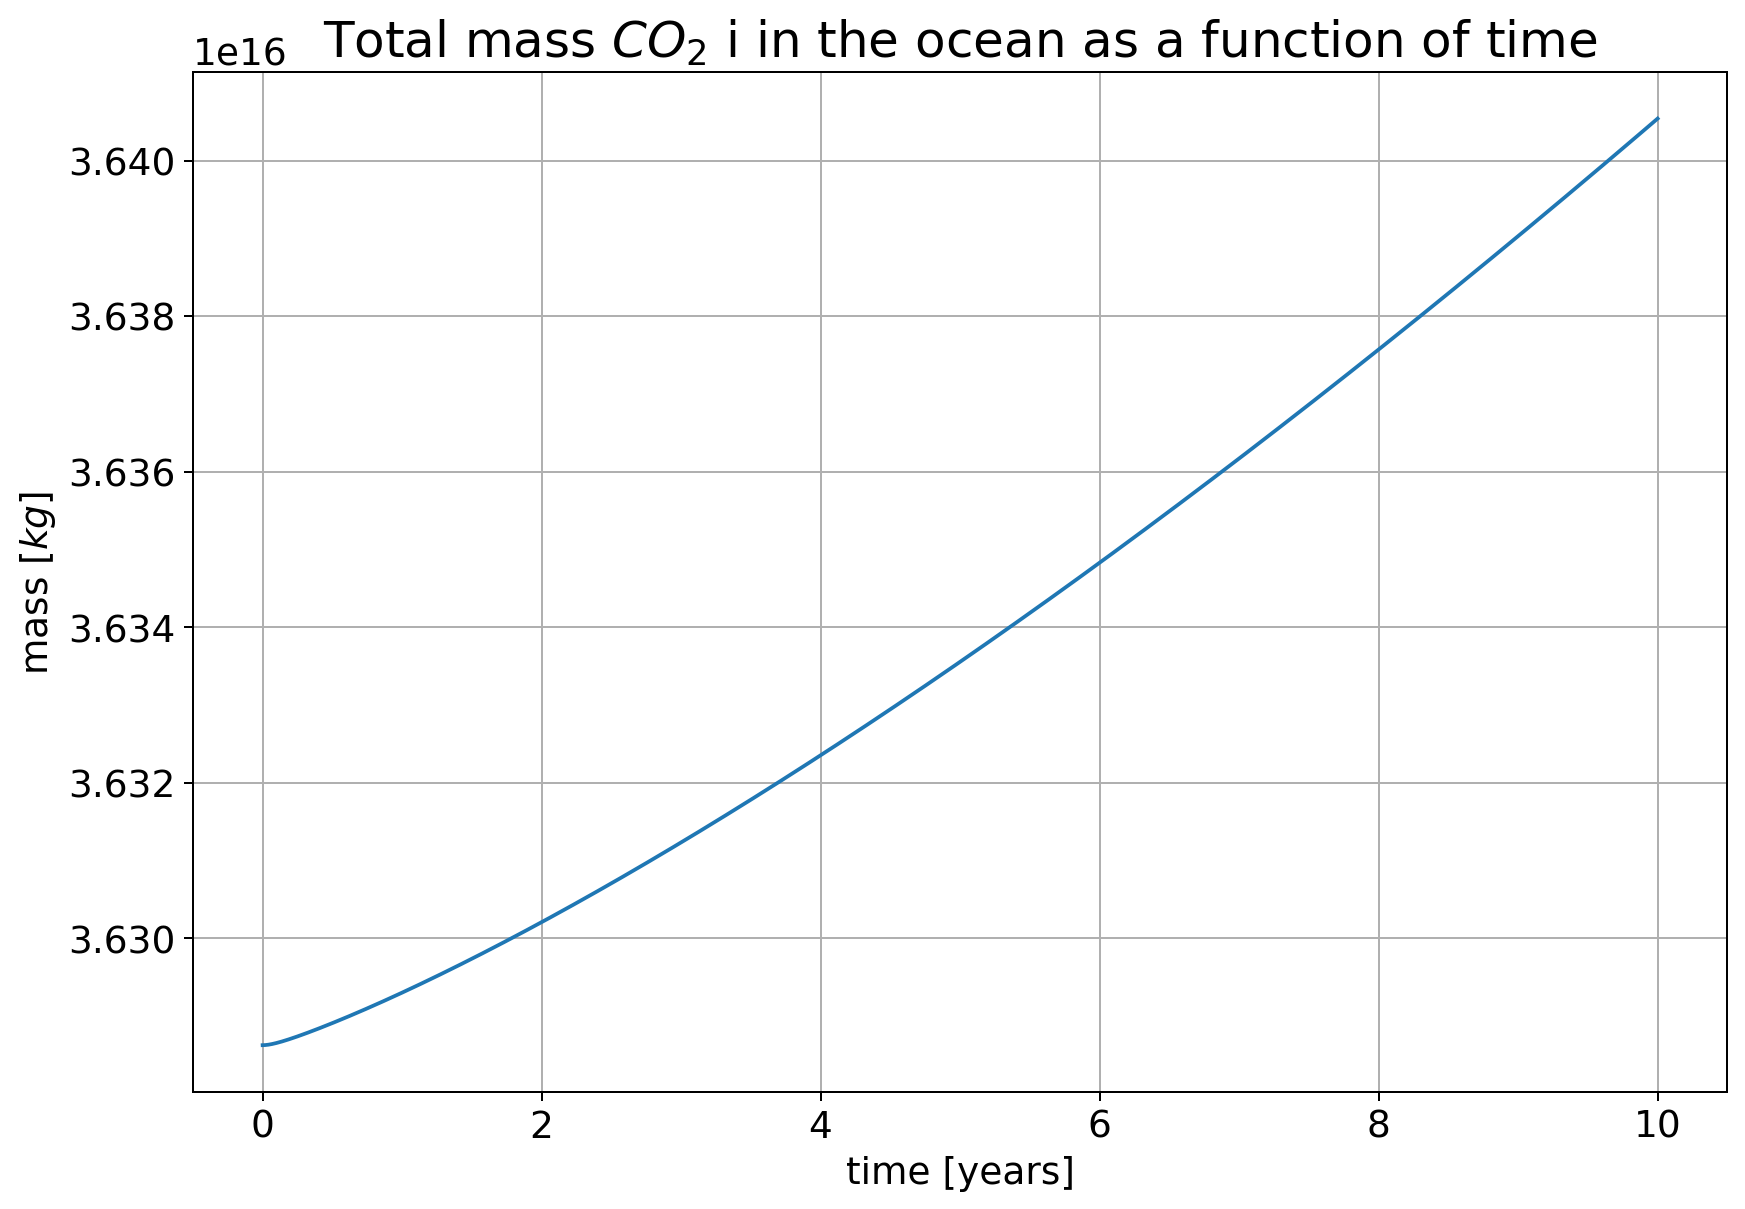

In [21]:
# Plotting the total mass CO2 in the ocean as a function of time
C_mass_kilo = C_mass*10**(-3)  # Creating an array of mass in kilograms

plt.figure()
plt.title('Total mass $CO_2$ i in the ocean as a function of time', fontsize = 20)
plt.plot(years, C_mass_kilo, label='time [$s$]')
plt.ylabel('mass [$kg$]')
plt.xlabel('time [years]')
plt.show()

We see that the mass will increase rather linear throughout the simulation which corresponds to the linear increase of CO2 in the atmosphere.

## Task 2.4: Amount of CO<sub>2</sub> absorbed by the entire global ocean

In [22]:
diff = C_mass[N]-C_mass[0] 
# difference total mass C02

average = diff/10 #average over 10 year: CO2 absorbed by entire global ocean in one year
print(f'average: {average}')

average: 1.1914061487908044e+16


To find the amount of CO<sub>2</sub> absorbed by the entire global ocean in a year we calculate the difference in mass from the start of the simulation to the end. We then find the average per year by dividing the difference by the amount of years.

The average over ten years is 1.19 $\cdot$10<sup>16</sup> g

## Task 2.5: Anthropogenic CO<sub>2</sub> and simplifications

As stated in the project description, researchers have found that anthropogenic CO<sub>2</sub> is absorbed at a rate of 2.5 $\cdot$ 10<sup>15</sup> g per year. Since 2.5 $\cdot$ 10<sup>15</sup> g is approximately one fifth of 1.19 $\cdot$10<sup>16</sup> g, anthropogenic CO<sub>2</sub> is a significally amount of CO<sub>2</sub> in the ocean. In this problem we make several simplifications, for example neglecting marine life. It is stated that photosynthesis in the world's oceans consumes approximately 50 $\cdot$ 10<sup>15</sup> g of carbon every year. If this had been taken into consideration, the level of CO<sub>2</sub> in the ocean would have been lower.

Our results indicates that the depth of the mixed layer is approximately 100 meters, but in real life, the depth, as well as the value of diffusivity at the different levels in the ocean will vary with local conditions such as wind, time of the year and other factors.

To simplify the model it is assumed that all CO<sub>2</sub> that enters the ocean is immediately transformed into DIC. This is not necessarily the case as it can take longer for all CO<sub>2</sub> to transform. This will cause the actual amount of CO<sub>2</sub> in the ocean to be less than what we are calculating with. Another simplification is looking at the system as one dimensional. This will imply that the concentration in the sea is identical for each depth, which is not necessarily the case, and the calculations may for these reasons, be wrong.